In [1]:
import os
import sys
import numpy as np
import mxnet as mx
import skimage.io
import argparse
import pandas as pd
import importlib

In [2]:
sys.path.append(os.path.join(os.getcwd(),'dataset'))
from detect.detector import Detector

In [3]:
CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

In [4]:
def get_detector(net, prefix, epoch, data_shape, mean_pixels, ctx,
                 nms_thresh=0.5, force_nms=True):
    """
    wrapper for initialize a detector

    Parameters:
    ----------
    net : str
        test network name
    prefix : str
        load model prefix
    epoch : int
        load model epoch
    data_shape : int
        resize image shape
    mean_pixels : tuple (float, float, float)
        mean pixel values (R, G, B)
    ctx : mx.ctx
        running context, mx.cpu() or mx.gpu(?)
    force_nms : bool
        force suppress different categories
    """
    sys.path.append(os.path.join(os.getcwd(), 'symbol'))
    net = importlib.import_module("symbol_" + net) \
        .get_symbol(len(CLASSES), nms_thresh, force_nms)
    detector = Detector(net, prefix + "_" + str(data_shape), epoch, \
        data_shape, mean_pixels, ctx=ctx)
    return detector


In [5]:
def default_args():
    args = pd.Series()
    args['network']= 'vgg16_reduced'
    args['images'] = ['dog','person']
    args['dir']= './data/demo/'
    args['extension'] = '.jpg'
    args['epoch']  = 0
    args['prefix'] = os.path.join(os.getcwd(), 'model', 'ssd')
    args['cpu'] = True
    args['data_shape']=300
    args['mean_r']=123
    args['mean_g']=117
    args['mean_b']=104
    args['thresh']=0.5
    args['nms_thresh']=0.5
    args['force_nms']=True
    args['show_timer']=True
    return args

Detection time for 2 images: 8.6917 sec


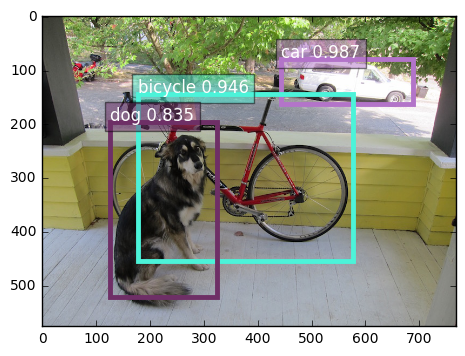

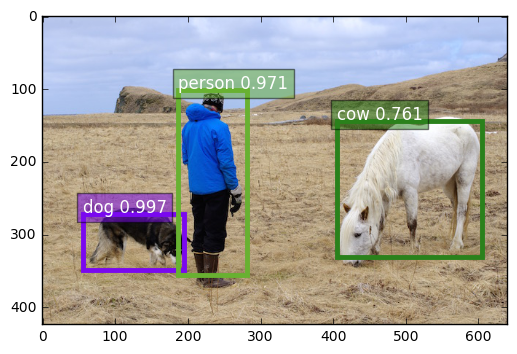

In [6]:
args = default_args()
if args.cpu:
    ctx = mx.cpu()
else:
    ctx = mx.gpu()

# parse image list
image_list = args.images
assert len(image_list) > 0, "No valid image specified to detect"

detector = get_detector(args.network, args.prefix, args.epoch,
                        args.data_shape,
                        (args.mean_r, args.mean_g, args.mean_b),
                        ctx, args.nms_thresh, args.force_nms)
# run detection
detector.detect_and_visualize(image_list, args.dir, args.extension,
                               CLASSES, args.thresh, args.show_timer)